In [1]:
# load autoreload extension
%load_ext autoreload
%autoreload 2

In [2]:
import os
# os.environ['JAX_PLATFORMS']="cpu"
os.environ['JAX_PLATFORMS']="cuda"

In [3]:
overwrite_model=False
restore_model=False
train_model=True

In [4]:
import orbax.checkpoint as ocp
checkpoint_dir = "/lhome/ific/a/aamerio/github/cfm-jax/checkpoints/two_moons_jflux_v3"

os.makedirs(checkpoint_dir, exist_ok=True)

if overwrite_model:
    checkpoint_dir = ocp.test_utils.erase_and_create_empty(checkpoint_dir)

In [5]:
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import optax
from optax.contrib import reduce_on_plateau

import numpy as np

from tqdm.auto import tqdm

from functools import partial

from flax import nnx

from corner import corner

/lhome/ific/a/aamerio/miniforge3/envs/cfm/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
PATIENCE = 10  # @param{type:"integer"}
# @markdown Number of epochs to wait before resuming normal operation after the learning rate reduction:
COOLDOWN = 5  # @param{type:"integer"}
# @markdown Factor by which to reduce the learning rate:
FACTOR = 0.5  # @param{type:"number"}
# @markdown Relative tolerance for measuring the new optimum:
RTOL = 1e-4  # @param{type:"number"}
# @markdown Number of iterations to accumulate an average value:
ACCUMULATION_SIZE = 100

In [7]:
import sys 
sys.path.append("examples/sbi-benchmarks")
sys.path.append("src/")
sys.path.append("/lhome/ific/a/aamerio/github/cfm-jax/src")

In [8]:
import sbibm
from utils.sbi_tasks import TwoMoons

from models import FluxParams, Flux, FluxCFMLoss


from flow_matching.path.scheduler import CondOTScheduler
from flow_matching.path import AffineProbPath
from flow_matching.solver import ODESolver

from flow_matching.utils import ModelWrapper, GuidedModelWrapper

In [9]:
twomoons = TwoMoons()
task = twomoons.task
prior = twomoons.get_prior()
simulator = twomoons.get_simulator()
observation = twomoons.get_observation(1)

theta = prior.sample((10_000,))
xs = simulator(theta)

In [10]:
@partial(jax.jit, static_argnames=["size"])
def sample_prior(size):
    return jnp.array(prior.sample((size,)))

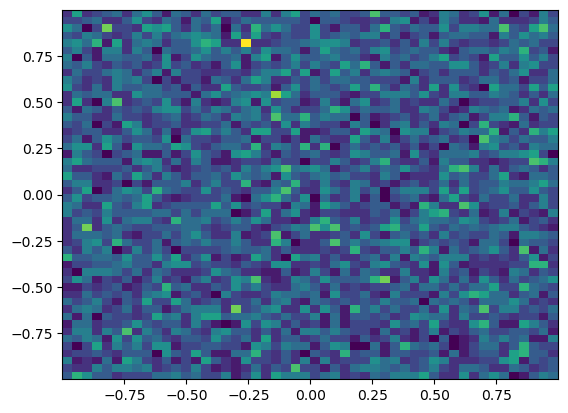

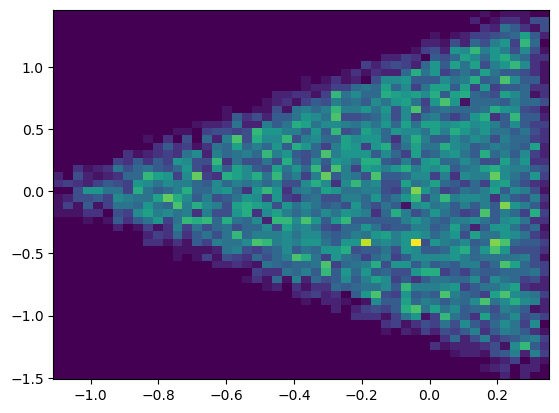

In [11]:
plt.hist2d(theta[:,0],theta[:,1], bins=50, density=True)
plt.show()

plt.hist2d(xs[:,0],xs[:,1], bins=50, density=True)
plt.show()

In [12]:
from sbibm.algorithms import rej_abc  # See help(rej_abc) for keywords
posterior_samples, _, _ = rej_abc(task=task, num_samples=10_000, num_observation=8, num_simulations=100_000)


Running REJ-ABC
INFO:sbibm.algorithms.sbi.mcabc:Running REJ-ABC
Running 100000 simulations.:   0%|          | 0/100000 [00:00<?, ?it/s]

Running 100000 simulations.: 100%|██████████| 100000/100000 [00:00<00:00, 2402965.39it/s]
/lhome/ific/a/aamerio/miniforge3/envs/cfm/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
100 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/lhome/ific/a/aamerio/miniforge3/envs/cfm/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 864, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "/lhome/ific/a/aamerio/miniforge3/envs/cfm/lib/python3.12/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/lhome/ific

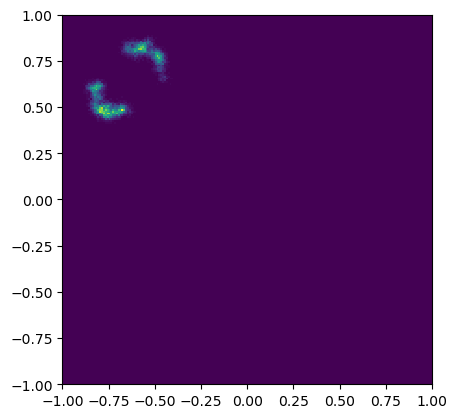

In [13]:
plt.hist2d(posterior_samples[:, 0], posterior_samples[:, 1], bins=(200,200), range=[(-1, 1), (-1, 1)], density=True)
plt.xlim((-1,1))
plt.ylim((-1,1))
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

/tmp/ipykernel_193214/563728433.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  corner(np.array(posterior_samples), bins=100, smooth=True, smooth1d=True, range=[(-1, 1), (-1, 1)])


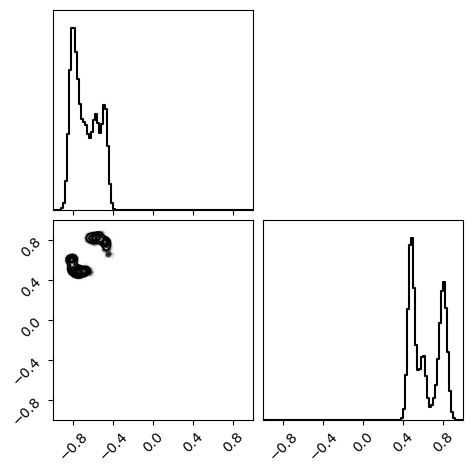

In [14]:
corner(np.array(posterior_samples), bins=100, smooth=True, smooth1d=True, range=[(-1, 1), (-1, 1)])
plt.show(9)

In [15]:
# Once we got samples from an approximate posterior, compare them to the reference:
from sbibm.metrics import c2st
reference_samples = task.get_reference_posterior_samples(num_observation=1)

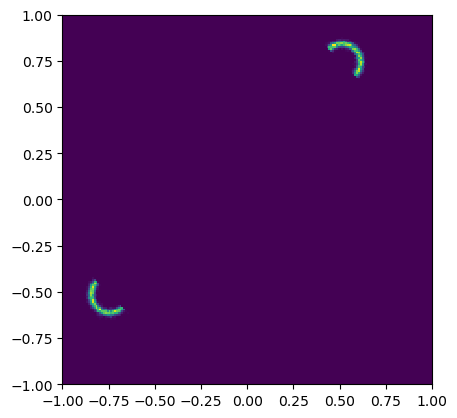

In [16]:
plt.hist2d(reference_samples[:, 0], reference_samples[:, 1], bins=(200,200), range=[(-1, 1), (-1, 1)], density=True)
plt.xlim((-1,1))
plt.ylim((-1,1))
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [17]:
# c2st_accuracy = c2st(reference_samples, posterior_samples)

In [18]:
# c2st_accuracy # around 0.6

# dataset

In [19]:
# make a dataset
train_size = int(1e6)
val_size = 512

nsamples = train_size + val_size
theta = prior.sample((nsamples,))
xs = jnp.array(simulator(theta))
node_ids = jnp.array(twomoons.get_node_id())
dim_theta = twomoons.get_theta_dim()
dim_x = twomoons.get_x_dim()

# turn them into jax arrays
theta = jnp.array(theta)
xs = jnp.array(xs)

# concatenate the data, theta and xs
data = jnp.concatenate((theta, xs), axis=-1)

train_data = data[:train_size]
val_data = data[train_size:]


In [20]:
# make an infinite dataloader that shuffles the data once it finishes cycling it
class InfiniteDataLoader:
    def __init__(self, data, batch_size, *, rngs: nnx.Rngs):
        self.data = jnp.asarray(data)
        self.batch_size = batch_size
        self.index = 0
        self.rngs = rngs

        self.data_mean = jnp.mean(data, axis=0)
        self.data_std = jnp.std(data, axis=0)

        # self.data = self.normalize(self.data)

    def normalize(self, unnormalized_data):
        # Normalize the data to be between 0 mean and unit varainve
        data = unnormalized_data - self.data_mean
        data = data / self.data_std

        return data

    def unnormalize(self, normdata):
        # Unnormalize the data
        data = normdata * self.data_std
        data = data + self.data_mean
        return data

    def __iter__(self):
        return self

    def __next__(self):
        if self.index >= len(self.data):
            self._shuffle()
        batch = self.data[self.index : self.index + self.batch_size]
        self.index += self.batch_size
        return batch

    def __len__(self):
        return len(self.data) // self.batch_size

    def __getitem__(self, index):
        return self.data[index]

    def _shuffle(self):
        self.data = jax.random.permutation(self.rngs.perm(), self.data)
        self.index = 0

In [21]:
batch_size = 1024 * 4
dataset = InfiniteDataLoader(train_data, batch_size, rngs=nnx.Rngs(0))

# Utils

In [22]:
cond_ids = jnp.arange(dim_theta, dtype=jnp.int32).reshape(1,-1,1)
obs_ids = jnp.arange(dim_x, dtype=jnp.int32).reshape(1,-1,1)

In [23]:
from einops import rearrange

class FluxWrapper(ModelWrapper):
    def __init__(self, model):
        super().__init__(model)

    def __call__(self, x, t, args, **kwargs):
        x = jnp.atleast_1d(x)
        t = jnp.atleast_1d(t)

        if x.ndim < 3:
            x = rearrange(x, '... -> 1 ... 1' if x.ndim == 1 else '... -> ... 1')

        return jnp.squeeze(self.model(obs=x, timesteps=t, conditioned=True, **kwargs), axis=-1)

In [24]:
def get_samples(vf_wrapped, idx, nsamples=10_000):
    observation =  jnp.array(twomoons.get_observation(idx))
    true_param = jnp.array(task.get_true_parameters(idx))
    reference_samples = task.get_reference_posterior_samples(num_observation=idx)

    rng = jax.random.PRNGKey(45)

    step_size = 0.01

    key1,key2 = jax.random.split(rng, 2)

    x_init = jax.random.normal(key1,(nsamples, dim_theta)) # n, T_max, 1
    cond = jnp.broadcast_to(observation[...,None], (nsamples, dim_x, 1)) # n, dim_theta, 1

    solver = ODESolver(velocity_model=vf_wrapped)  # create an ODESolver class
    model_extras = {"cond": cond, "obs_ids": obs_ids, "cond_ids": cond_ids}

    sampler_ = solver.get_sampler(method='Dopri5', step_size=step_size, return_intermediates=False, model_extras=model_extras)
    samples = sampler_(x_init)  # sample from the model

    return samples, true_param, reference_samples

def plot_samples(samples, true_param):
    plt.hist2d(samples[:,0], samples[:,1], bins=(200,200), range=[(-1, 1), (-1, 1)], density=True)
    # same ratio on axis 
    plt.scatter(true_param[0,0], true_param[0,1], s=100, color='red', alpha=0.5, marker='x')
    # plt.scatter(reference_samples[:,0], reference_samples[:,1], s=0.1, color='red', alpha=0.1, marker='x')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlim((-1,1))
    plt.ylim((-1,1))
    plt.show()


# define the CFM model

In [25]:
path = AffineProbPath(scheduler=CondOTScheduler()) # define the probability path

In [26]:
#v1 v2
# params=FluxParams(
#             in_channels=1,
#             vec_in_dim=None,
#             context_in_dim=1,
#             mlp_ratio=4,
#             qkv_bottleneck=1,  
#             num_heads=4,
#             depth=4,
#             depth_single_blocks=8,
#             axes_dim=[10,],
#             use_rope = False,
#             obs_dim = 2,
#             cond_dim = 2,
#             qkv_bias=True,
#             guidance_embed=False,
#             rngs=nnx.Rngs(default=42),
#             param_dtype=jnp.bfloat16,
#         )

# v3
params=FluxParams(
            in_channels=1,
            vec_in_dim=None,
            context_in_dim=1,
            mlp_ratio=3,
            qkv_bottleneck=1,  
            num_heads=4,
            depth=8,
            depth_single_blocks=8,
            axes_dim=[10,],
            use_rope = False,
            obs_dim = 2,
            cond_dim = 2,
            qkv_bias=True,
            guidance_embed=False,
            rngs=nnx.Rngs(default=42),
            param_dtype=jnp.bfloat16,
        )

In [27]:
vf_model = Flux(params)

In [28]:
loss_fn_cfm = FluxCFMLoss(path, cfg_scale=0.9)

In [29]:
# restore the model
if restore_model:
    model_state = nnx.state(vf_model)
    graphdef, abstract_state = nnx.split(vf_model)

    with ocp.CheckpointManager(
        checkpoint_dir, options=ocp.CheckpointManagerOptions(read_only=True)
    ) as read_mgr:
        restored = read_mgr.restore(
            2,
            # pass in the model_state to restore the exact same State type
            args=ocp.args.Composite(state=ocp.args.PyTreeRestore(item=model_state))
        )

    vf_model= nnx.merge(graphdef, restored["state"])
    print("Restored model from checkpoint")

In [30]:
from numpyro import distributions as dist

p0_dist_model = dist.Independent(
    dist.Normal(loc=jnp.zeros((4,)), scale=jnp.ones((4,))),
    reinterpreted_batch_ndims=1
)

In [31]:
@nnx.jit
def train_loss(vf_model, key: jax.random.PRNGKey):
    batch = next(dataset)
    obs = batch[:,:2][...,None]
    cond = batch[:,2:][...,None]

    key1, key2 = jax.random.split(key, 2)

    x_1 = obs
    x_0 = jax.random.normal(key1, x_1.shape)
    t = jax.random.uniform(key2, x_1.shape[0])

    batch = (x_0, x_1, t)

    loss=loss_fn_cfm(vf_model, batch, cond, obs_ids, cond_ids)
    return loss

@nnx.jit
def val_loss(vf_model, key: jax.random.PRNGKey):
    batch = val_data
    obs = batch[:,:2][...,None]
    cond = batch[:,2:][...,None]

    key1, key2 = jax.random.split(key, 2)

    x_1 = obs
    x_0 = jax.random.normal(key1, x_1.shape)
    t = jax.random.uniform(key2, x_1.shape[0])

    batch = (x_0, x_1, t)

    loss=loss_fn_cfm(vf_model, batch, cond, obs_ids, cond_ids)
    return loss

In [32]:
@nnx.jit
def train_step(model, optimizer, rng):
    loss_fn = lambda model: train_loss(model, rng)
    loss, grads = nnx.value_and_grad(loss_fn)(model)
    optimizer.update(grads, value=loss)  # In place updates.
    return loss

In [33]:
rngs = nnx.Rngs(0)

In [34]:
nsteps = 10_000
nepochs = 5

fixed_steps = 2000
total_steps = nsteps * nepochs

# # multistep=2



# schedule = optax.schedules.linear_schedule(1e-3, 1e-6, total_steps-fixed_steps, fixed_steps)

# opt = optax.chain(optax.adaptive_grad_clip(10.0), optax.adamw(schedule))



# # opt = optax.chain(
# #     # optax.adaptive_grad_clip(10.0),
# #     optax.adamw(1e-3),
# #     reduce_on_plateau( 
# #         patience=PATIENCE,
# #         cooldown=COOLDOWN,
# #         factor=FACTOR,
# #         rtol=RTOL,
# #         accumulation_size=ACCUMULATION_SIZE,
# #     ),
# # )

# # opt = optax.MultiSteps(opt, multistep)
# optimizer = nnx.Optimizer(vf_model, opt)

In [35]:
# multistep=2



# schedule = optax.schedules.linear_schedule(1e-3, 1e-6, total_steps-fixed_steps, fixed_steps)

# opt = optax.chain(optax.adaptive_grad_clip(10.0), optax.adamw(schedule))

# opt = optax.MultiSteps(opt, multistep)
# optimizer = nnx.Optimizer(vf_model, opt)

In [36]:
multistep=2

# schedule = optax.schedules.linear_schedule(1e-3, 1e-6, total_steps-fixed_steps, fixed_steps)


opt = optax.chain(
    optax.adaptive_grad_clip(10.0),
    optax.adamw(1e-3),
    reduce_on_plateau( 
        patience=PATIENCE,
        cooldown=COOLDOWN,
        factor=FACTOR,
        rtol=RTOL,
        accumulation_size=ACCUMULATION_SIZE,
    ),
)

# opt = optax.MultiSteps(opt, multistep)
optimizer = nnx.Optimizer(vf_model, opt)

In [37]:
best_state = nnx.state(vf_model)
val_loss_value = val_loss(vf_model, jax.random.PRNGKey(0))
val_error_ratio = 1.1
counter = 0
cmax = 10
print_every = 100
early_stopping = True

loss_array = []
val_loss_array = []
# early_stopping = False


 30%|███       | 3000/10000 [06:48<09:40, 12.06it/s, counter=0, loss=0.3536, ratio=1.0976, val_loss=0.3881]

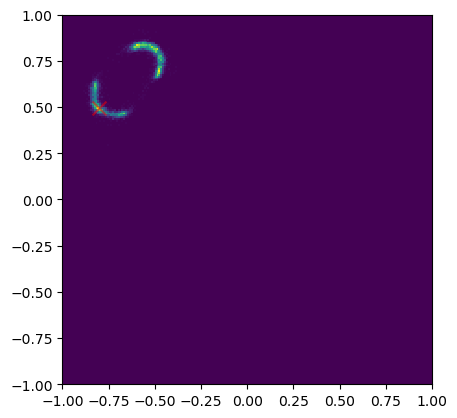

 42%|████▏     | 4201/10000 [08:53<12:15,  7.88it/s, counter=11, loss=0.3269, ratio=1.2952, val_loss=0.4234] 


Early stopping


  0%|          | 0/10000 [00:00<?, ?it/s]


Early stopping


  0%|          | 0/10000 [00:00<?, ?it/s]


Early stopping


  0%|          | 0/10000 [00:00<?, ?it/s]


Early stopping


  0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping


In [38]:
if train_model:
    vf_model.train()

    for ep in range(nepochs):
        pbar = tqdm(range(nsteps))
        l = 0
        v_l = 0
        for j in pbar:
            if counter > cmax and early_stopping:
                print("Early stopping")
                # restore the model state
                graphdef, abstract_state = nnx.split(vf_model)

                vf_model = nnx.merge(graphdef, best_state)
                break
            
            loss = train_step(vf_model, optimizer, rngs.train_step())
            v_loss = val_loss(vf_model, rngs.val_step())
            l += loss.item()
            v_l += v_loss.item()
            if j>0 and j % 100 == 0:
                loss_ = l/100
                val_ = v_l/100

                ratio = val_ / loss_
                
                if ratio < val_error_ratio:
                    val_loss_value = val_
                    counter = 0
                    best_state = nnx.state(vf_model)
                else:
                    counter += 1
                
                # scale = tree_get(optimizer.opt_state, "ReduceLROnPlateauState").scale.value
                # pbar.set_postfix(loss=f"{l/(100):.4f}", ratio=f"{ratio:.4f}", counter=counter, lr_scale=scale, val_loss = f"{val_:.4f}" )
                pbar.set_postfix(loss=f"{loss_:.4f}", ratio=f"{ratio:.4f}", counter=counter, val_loss = f"{val_:.4f}" )
                loss_array.append(loss_)
                val_loss_array.append(val_) 
                l=0
                v_l=0

            if j>0 and j%3000 == 0:
                idx = 8
                vf_wrapped = FluxWrapper(vf_model)
                samples, true_param, reference_samples = get_samples(vf_wrapped, idx)
                plot_samples(samples, true_param)
        # print(l)



    vf_model.eval()

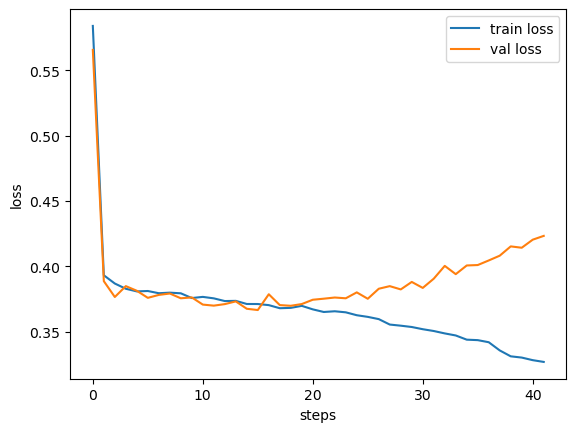

In [39]:
plt.plot(loss_array, label="train loss")
plt.plot(val_loss_array, label="val loss")
plt.xlabel("steps")
plt.ylabel("loss")
plt.legend()
plt.show()

In [40]:
# save the model
if train_model:
    checkpoint_manager = ocp.CheckpointManager(checkpoint_dir,
        options=ocp.CheckpointManagerOptions(
            max_to_keep=2,
            keep_checkpoints_without_metrics=False,
            create=True,
        ),
    )
    model_state = nnx.state(vf_model)
    checkpoint_manager.save(
        3, args=ocp.args.Composite(state=ocp.args.PyTreeSave(model_state))
    )

    checkpoint_manager.close()

ERROR:absl:File /lhome/ific/a/aamerio/github/cfm-jax/checkpoints/two_moons_jflux_v3/2/metrics/metrics not found.
ERROR:absl:File /lhome/ific/a/aamerio/github/cfm-jax/checkpoints/two_moons_jflux_v3/3/metrics/metrics not found.


# sample the posterior

In [41]:
idx = 8
vf_wrapped = FluxWrapper(vf_model)
samples, true_param, reference_samples = get_samples(vf_wrapped, idx, 100_000)


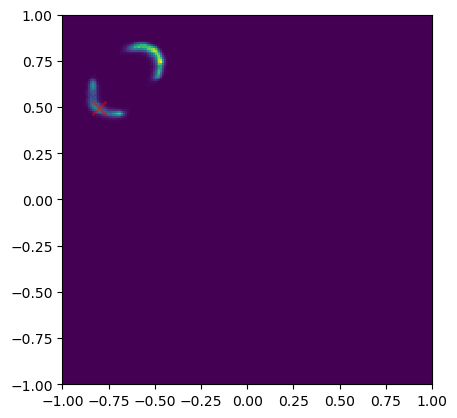

In [42]:
plot_samples(samples, true_param)

d4 s4 cfg 1 <br>
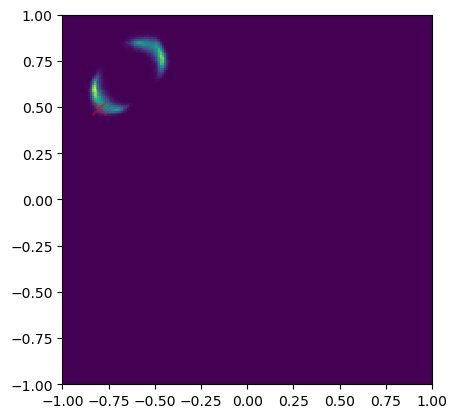

d1 s4 cfg 1<br>
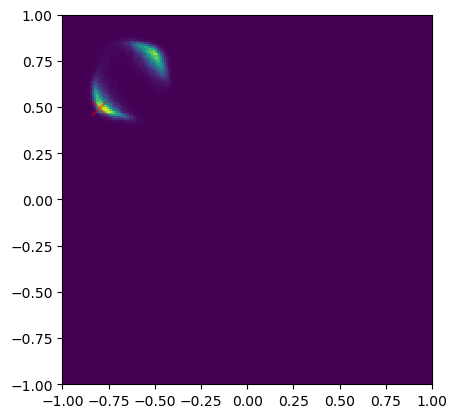

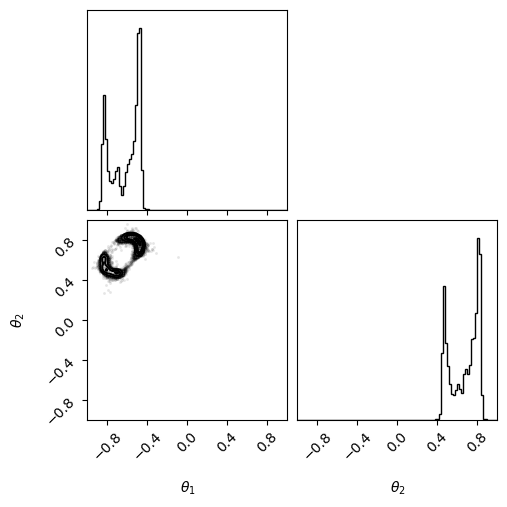

In [43]:
from corner import corner
corner(np.array(samples), bins=100, smooth=True, range=[(-1, 1), (-1, 1)], labels=['$\\theta_1$', '$\\theta_2$'])
plt.show()

d4 s4 cfg 1 <br>
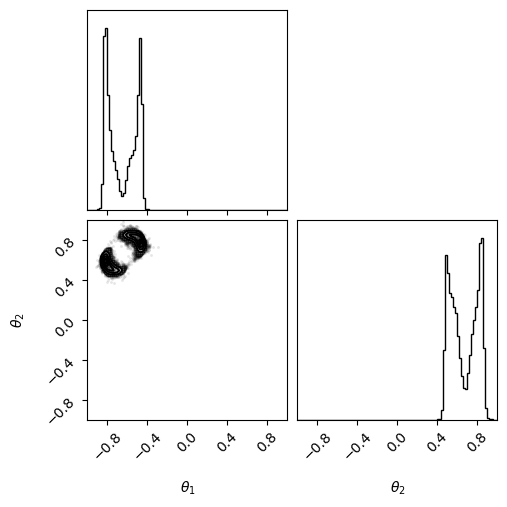

d1 s4 cfg 1<br>
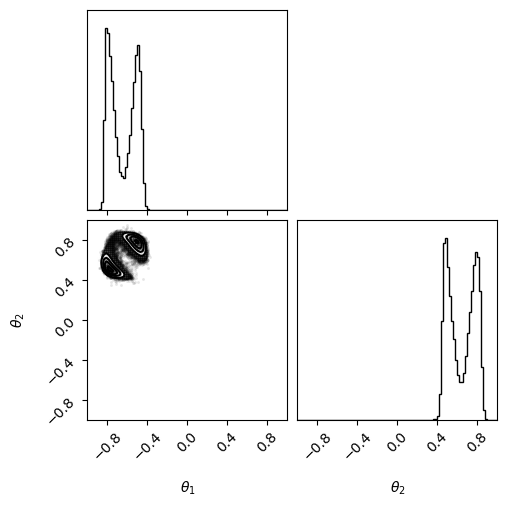

/tmp/ipykernel_193214/1071246627.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  corner(np.array(reference_samples), bins=100, smooth=True, range=[(-1, 1), (-1, 1)], labels=['$\\theta_1$', '$\\theta_2$'])


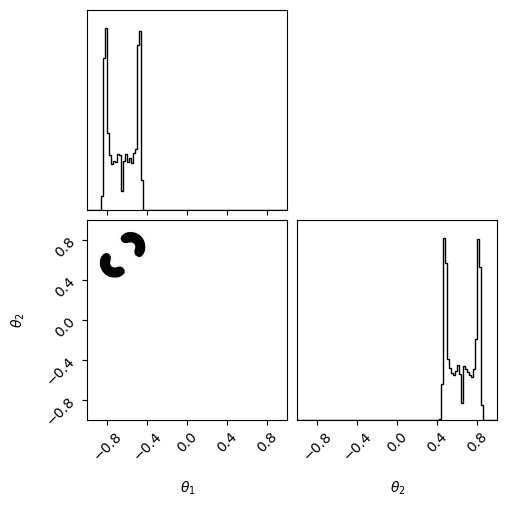

In [44]:
corner(np.array(reference_samples), bins=100, smooth=True, range=[(-1, 1), (-1, 1)], labels=['$\\theta_1$', '$\\theta_2$'])
plt.show()

# sample with guidance

In [45]:
from einops import rearrange

class GuidedFluxWrapper(GuidedModelWrapper):
    def __init__(self, model, cfg_scale=0.7):
        super().__init__(model, cfg_scale=cfg_scale)

    def __call__(self, x, t, args, **kwargs):
        x = jnp.atleast_1d(x)
        t = jnp.atleast_1d(t)

        if x.ndim < 3:
            x = rearrange(x, '... -> 1 ... 1' if x.ndim == 1 else '... -> ... 1')
        # t = t.reshape(-1,1, 1)
        return jnp.squeeze(self.model(obs=x, timesteps=t, **kwargs), axis=-1)
        # return self.model(obs=x, timesteps=t, **kwargs)

In [46]:
gvf_wrapped = GuidedFluxWrapper(vf_model, cfg_scale=0.95)

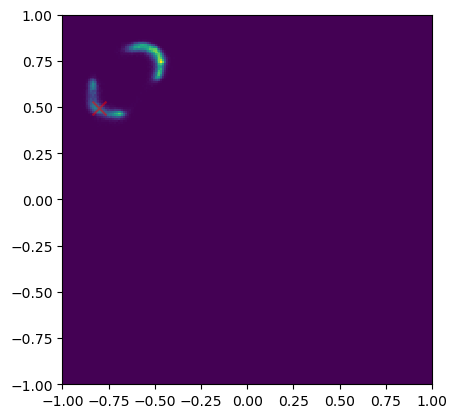

In [47]:
samples_cfg = get_samples(gvf_wrapped, idx, 100_000)[0]
plot_samples(samples_cfg, true_param)

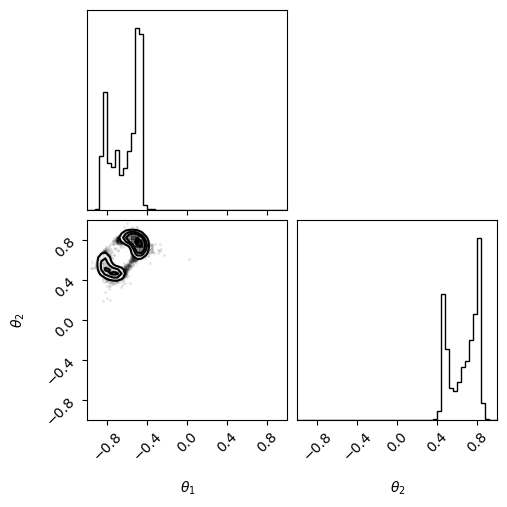

In [48]:
corner(np.array(samples_cfg), bins=50, smooth=True, range=[(-1, 1), (-1, 1)], labels=['$\\theta_1$', '$\\theta_2$'])
plt.show()

# C2ST test

In [53]:
# we want to do conditional inference. We need an observation for which we want to ocmpute the posterior
idx = 2

samples, true_param, reference_samples = get_samples(vf_wrapped, idx, 10_000)
samples_cfg = get_samples(gvf_wrapped, idx, 10_000)[0]


In [54]:
# # convert posterior samples to a torch array
import torch
samples_torch = torch.tensor(np.array(samples))
samples_cfg_torch = torch.tensor(np.array(samples_cfg))

In [55]:

c2st_accuracy = c2st(reference_samples, samples_torch)
c2st_accuracy_cfg = c2st(reference_samples, samples_cfg_torch)

In [56]:
c2st_accuracy, c2st_accuracy_cfg

(tensor([0.5766]), tensor([0.5978]))